In [1]:
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class Generator(nn.Module):
    def __init__(self, latent_dim, layers, output_activation=None):
        """A generator for mapping a latent space to a sample space.
        Args:
            latent_dim (int): latent dimension ("noise vector")
            layers (List[int]): A list of layer widths including output width
            output_activation: torch activation function or None
        """
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.output_activation = output_activation
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.latent_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
        else:
            if self.output_activation is not None:
                self.module_list.append(self.output_activation())

    def forward(self, input_tensor):
        """Forward pass; map latent vectors to samples."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate


class Discriminator(nn.Module):
    def __init__(self, input_dim, layers):
        """A discriminator for discerning real from generated samples.
        params:
            input_dim (int): width of the input
            layers (List[int]): A list of layer widths including output width
        Output activation is Sigmoid.
        """
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self._init_layers(layers)

    def _init_layers(self, layers):
        """Initialize the layers and store as self.module_list."""
        self.module_list = nn.ModuleList()
        last_layer = self.input_dim
        for index, width in enumerate(layers):
            self.module_list.append(nn.Linear(last_layer, width))
            last_layer = width
            if index + 1 != len(layers):
                self.module_list.append(nn.LeakyReLU())
        else:
            self.module_list.append(nn.Sigmoid())

    def forward(self, input_tensor):
        """Forward pass; map samples to confidence they are real [0, 1]."""
        intermediate = input_tensor
        for layer in self.module_list:
            intermediate = layer(intermediate)
        return intermediate


class VanillaGAN():
    def __init__(self, generator, discriminator, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_d=1e-3, lr_g=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            generator: a Ganerator network
            discriminator: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_d: learning rate for the discriminator
            lr_g: learning rate for the generator
        """
        self.generator = generator
        self.generator = self.generator.to(device)
        self.discriminator = discriminator
        self.discriminator = self.discriminator.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        self.criterion = nn.BCELoss()
        self.optim_d = optim.Adam(discriminator.parameters(),
                                  lr=lr_d, betas=(0.5, 0.999))
        self.optim_g = optim.Adam(generator.parameters(),
                                  lr=lr_g, betas=(0.5, 0.999))
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)

    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        with torch.no_grad():
            samples = self.generator(latent_vec)
        return samples

    def train_step_generator(self):
        """Train the generator one step and return the loss."""
        self.generator.zero_grad()

        latent_vec = self.noise_fn(self.batch_size)
        generated = self.generator(latent_vec)
        classifications = self.discriminator(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_g.step()
        return loss.item()

    def train_step_discriminator(self):
        """Train the discriminator one step and return the losses."""
        self.discriminator.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        pred_real = self.discriminator(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        with torch.no_grad():
            fake_samples = self.generator(latent_vec)
        pred_fake = self.discriminator(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_d.step()
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_d = self.train_step_discriminator()
        loss_g = self.train_step_generator()
        return loss_g, loss_d


def main():
    from time import time
    epochs = 100
    batches = 100
    generator = Generator(1, [64, 32, 1])
    discriminator = Discriminator(1, [64, 32, 1])
    noise_fn = lambda x: torch.rand((x, 1), device='cpu')
    data_fn = lambda x: torch.randn((x, 1), device='cpu')
    gan = VanillaGAN(generator, discriminator, noise_fn, data_fn, device='cpu')
    loss_g, loss_d_real, loss_d_fake = [], [], []
    start = time()
    for epoch in range(epochs):
        loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
        for batch in range(batches):
            lg_, (ldr_, ldf_) = gan.train_step()
            loss_g_running += lg_
            loss_d_real_running += ldr_
            loss_d_fake_running += ldf_
        loss_g.append(loss_g_running / batches)
        loss_d_real.append(loss_d_real_running / batches)
        loss_d_fake.append(loss_d_fake_running / batches)
        print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
              f" G={loss_g[-1]:.3f},"
              f" Dr={loss_d_real[-1]:.3f},"
              f" Df={loss_d_fake[-1]:.3f}")
#if __name__ == "__main__":
   # main()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
def noise_fn(num):
    return torch.rand((num, 1))

def target_fn(num):
    return torch.randn((num, 1))




gen = Generator(1, [64, 32, 1], output_activation=None)
disc = Discriminator(1, [64, 32, 1])
gan = VanillaGAN(gen, disc, noise_fn, target_fn,)
real_samples = np.random.normal(10, 1, 1000)
#real_samples = np.sort(real_samples)
z=np.zeros(20*10)
for ep in range(10):

    for i in range(1000):
    #print(i)
        for _ in range(100):
            gan.train_step()
        generated_samples = gan.generate_samples(num=20).cpu().numpy().flatten()
        generated_samples = np.sort(generated_samples)
    for ep1 in range(20):

        z[20*ep + ep1] = generated_samples[ep1]

#input()

-0.21515755
1.2153839


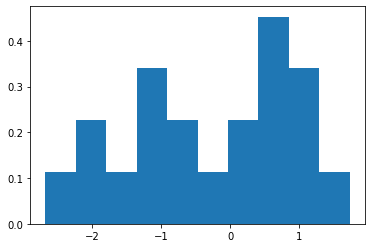

In [7]:
print(np.mean(generated_samples))
print(np.std(generated_samples))
plt.hist(generated_samples, density = True)
plt.show()

-0.0014043643698096275
1.0668751091856985


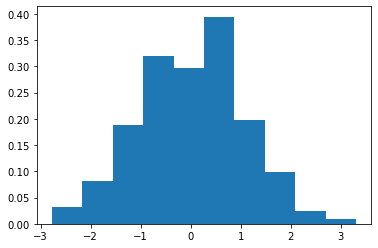

In [15]:
print(np.mean(z))
print(np.std(z))
plt.hist(z,bins=10, density = True)
plt.show()

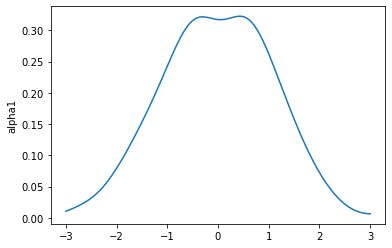

0.437185929648241

In [26]:
from scipy.stats.kde import gaussian_kde
density = gaussian_kde(z)
xs = np.linspace(-3,3,len(z))
plt.plot(xs,density(xs))
#plt.hist(K1,density=True)
#matplotlib.pyplot.title('marginal distribution of alpha1')
plt.ylabel('alpha1')
#plt.plot(K1,np.exp(-K3))
plt.show()
#statistics.mode(Kth_1)
a = (density(xs))
i = list(a).index(max(density(xs))) 
i
xs[i]

In [24]:
from numpy import trapz
area=trapz(a,xs,dx=.01)
print(area)

0.9929257244480441


In [ ]:
import numpy as np
y= np.random.normal(5,1,10)
z=np.zeros(10*10)
for it in range(10):

    x= np.random.normal(5,1,10)
    for it1 in range(10):
        z[10*it+it1]=x[it1]
    
    

    
    


In [ ]:
z

In [ ]:
np.std(z)

In [ ]:
z.shape

In [ ]:
import numpy as np
gen = Generator(1, [64, 32, 1])
disc = Discriminator(1, [64, 32, 1])
noise_fn = lambda x: torch.rand((x, 1), device='cpu')
data_fn = lambda x: torch.randn((x, 1), device='cpu')
gan = VanillaGAN(gen, disc, noise_fn, data_fn, device='cpu')
m = np.zeros(1000)
for j in range(1000):

    m[j]=gan.generate_samples(num=1).numpy().flatten()

In [ ]:
print(np.mean(m))
print(np.std(m))


print(m.shape)

In [ ]:
import matplotlib.pyplot as plt
k = np.zeros(1000)
for n in range(1000):
    input=torch.rand(1)
    k[n]=gen.forward(input).item()

In [ ]:
np.mean(k)

In [ ]:
plt.hist(k, density = True)
plt.show